# Impact of Steepner US_2y/US_10y in Sector Indices
by Guillaume IDAME KORALAGE

### Librairies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import percentileofscore, shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

import yfinance as yf
from fredapi import Fred
fred = Fred(api_key='7e837cc7acf42a85ad6d1ebee7c58204')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap
import plotly.io as pio
pio.renderers.default = "jupyterlab"

### Functions

In [2]:
def get_multi_timeseries(list_underlying, period_value, interval_value) :
    underlying_object = yf.Tickers(list_underlying)
    underlying_data = underlying_object.history(period = period_value, interval = interval_value)
    return underlying_data

In [3]:
def get_ols(df_X, df_y) :
    
    y = np.array(df_y)
    X = np.array(df_X)
    
    ols_pipeline = Pipeline(steps=[    
    ('scaler',StandardScaler()),
    ('ols',LinearRegression())
    ])

    ols_pipeline.fit(X, y)
    ols_coef = ols_pipeline.named_steps['ols'].coef_

    y_predict = ols_pipeline.predict(X)

    df_ols_coef = pd.DataFrame(ols_coef, index = ["Beta"], columns = df_X.columns)
    df_y_predict = pd.DataFrame(y_predict, index = df_y.index, columns = df_y.columns)
    
    y_Matrix = pd.concat([df_y, df_y_predict], axis = 1)
    y_Matrix.columns = ["y","y predict"]
    
    #R2 Score
    r2_score_value = r2_score(y_Matrix["y"],y_Matrix["y predict"])
    #Adj R2 Score
    adj_r2_score_value = 1 - (1-r2_score_value) * (len(df_y)-1)/(len(df_y)-df_X.shape[1]-1)
    
    score_metrics = pd.DataFrame({"R2 Score" : r2_score_value,
                             "Adj R2 Score" : adj_r2_score_value}, index = ["Metrics"])
    
    return df_ols_coef, y_Matrix, score_metrics

In [4]:
def get_volatility(df) : 
    frequency_return = df.pct_change().dropna()
    volatility = np.sqrt(252) * frequency_return.std()
    return volatility.dropna()

def get_skew(df) : 
    frequency_return = df.pct_change().dropna()
    skew = df.skew()
    return skew.dropna()

def get_robust_skew(df) : 
    frequency_return = df.pct_change().dropna()
    frequency_return_mean = frequency_return.mean()
    frequency_return_median = frequency_return.median()
    frequency_return_std = frequency_return.std()
    robust_skew = (frequency_return_mean - frequency_return_median) / frequency_return_std
    return robust_skew

def get_excess_kurtosis(df) : 
    frequency_return = df.pct_change().dropna()
    excess_kurtosis = df.kurt() - 3
    return excess_kurtosis.dropna()

def get_sharpe_ratio(df) : 
    frequency_return = df.pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * frequency_return.mean() / frequency_return.std()
    return sharpe_ratio

def get_max_drawdown(df):

    frequency_return = df.pct_change().dropna()
    cum_returns = (1 + frequency_return).cumprod()  # Calculate cumulative returns
    window = pd.DataFrame(index=df.index)  # DataFrame to store rolling maximum
    max_drawdown = pd.DataFrame(index=df.columns, columns=["Max Drawdown"])

    for column in cum_returns.columns:
        rolling_max = cum_returns[column].expanding(min_periods=1).max()  # Rolling maximum
        drawdown = cum_returns[column] / rolling_max - 1  # Drawdown calculation
        max_drawdown.loc[column, "Max Drawdown"] = drawdown.min()  # Maximum drawdown

    return max_drawdown

def get_norm_max_drawdown(df):
    volatility = get_volatility(df).to_frame(name = "Volatility")
    max_drawdown = get_max_drawdown(df)
    norm_max_drawdown = max_drawdown/volatility.values
    norm_max_drawdown.columns = ["Norm. Max Drawdown"]
    return norm_max_drawdown

def get_var(df, alpha = 0.05):
    frequency_return = df.pct_change().dropna()
    dict_var = {}
    for column in frequency_return.columns : 
        dict_var[column] = -np.percentile(frequency_return[column], alpha * 100)
    var = pd.DataFrame.from_dict(dict_var, orient = "index", columns = ["VAR " + str((1-alpha) * 100) + "%"])
    return var

def get_expected_shortfall(df, alpha=0.05):
    frequency_return = df.pct_change().dropna()
    dict_es = {}
    
    for column in frequency_return.columns:
        column_returns = frequency_return[column]
        var = -np.percentile(column_returns, alpha * 100)
        es = -np.mean(column_returns[column_returns <= var])
        dict_es[column] = es
    
    es_df = pd.DataFrame.from_dict(dict_es, orient="index", columns=["ES " + str((1-alpha) * 100) + "%"])
    return es_df

def get_risk_metrics(df) :
    volatility = get_volatility(df).to_frame(name = "Volatility")
    skew = get_skew(df).to_frame(name = "Skewness")
    excess_kurtosis = get_excess_kurtosis(df).to_frame(name = "Excess Kurtosis")
    sharpe_ratio = get_sharpe_ratio(df).to_frame(name = "Sharpe Ratio")
    max_drawdown = get_max_drawdown(df)
    norm_max_drawdown = get_norm_max_drawdown(df)
    var = get_var(df, alpha=0.01)
    expected_shortfall = get_expected_shortfall(df, alpha=0.01)


    risk_metrics = pd.concat([volatility,
                              skew, 
                              excess_kurtosis,
                              sharpe_ratio,
                              max_drawdown,
                              norm_max_drawdown,
                              var,
                              expected_shortfall], axis = 1)
    
    return risk_metrics

### Load Macro Data (FRED Api) & Market Data (yfinance API)

In [5]:
#Data Name
list_fred_code = ["DGS1MO","DGS3MO","DGS6MO","DGS1","DGS2","DGS3","DGS5","DGS10","DGS30"]
list_fred_name = ["US_1m","US_3m","US_6m","US_1y","US_2y","US_3y","US_5y","US_10y","US_30y"]

#Macro Rates
treasuries_data = pd.DataFrame({series:fred.get_series(series) for series in list_fred_code})
treasuries_data.columns = list_fred_name

In [6]:
#Data Name
dict_yahoo_code_name = {'XLY' : "SPDR U.S. Consumer Discretionary",
                 'XLP' : "SPDR U.S. Consumer Staples",
                 'XLE' : "SPDR U.S. Energy" ,
                 'XLF' : "SPDR U.S. Financials",
                 'XLV' : "SPDR U.S. Healthcare",
                 'XLI' : "SPDR U.S. Industrials",  
                 'XLB' : "SPDR U.S. Materials",  
                 'XLK' : "SPDR U.S. Technology",  
                 'XLU' : "SPDR U.S. Utilities"}

list_yahoo_codes = list(dict_yahoo_code_name.keys())
list_yahoo_name = list(dict_yahoo_code_name.values())

#Load Market Data
period_value = "max"
interval_value = "1d"
raw_market_data = get_multi_timeseries(list_yahoo_codes, period_value, interval_value)

#Close Price
close_price_data = raw_market_data.xs("Close", axis = 1)
dict_close_price_data = {}
for column in close_price_data.columns :
    dict_close_price_data[column] = close_price_data[column].to_frame(name = dict_yahoo_code_name[column])
close_price_data = pd.concat(dict_close_price_data.values(), axis=1).dropna(axis = 1, how = "all")

performance_close_price = close_price_data/close_price_data.iloc[0,:]

[*********************100%%**********************]  9 of 9 completed


### I - Analysis Macro & Market Data

#### 1) Steepner & 6m Change Steepner US_2y/US_10y

In [7]:
US2y10y = (treasuries_data["US_10y"] - treasuries_data["US_2y"]).ffill().dropna() * 100
US2y10y = US2y10y.to_frame(name = "US_2y/US_10y")

diff_6m_US2y10y = US2y10y.diff(periods = 6 * 22).dropna()
diff_6m_US2y10y.columns = ["6m Change US_2y/US_10y"]

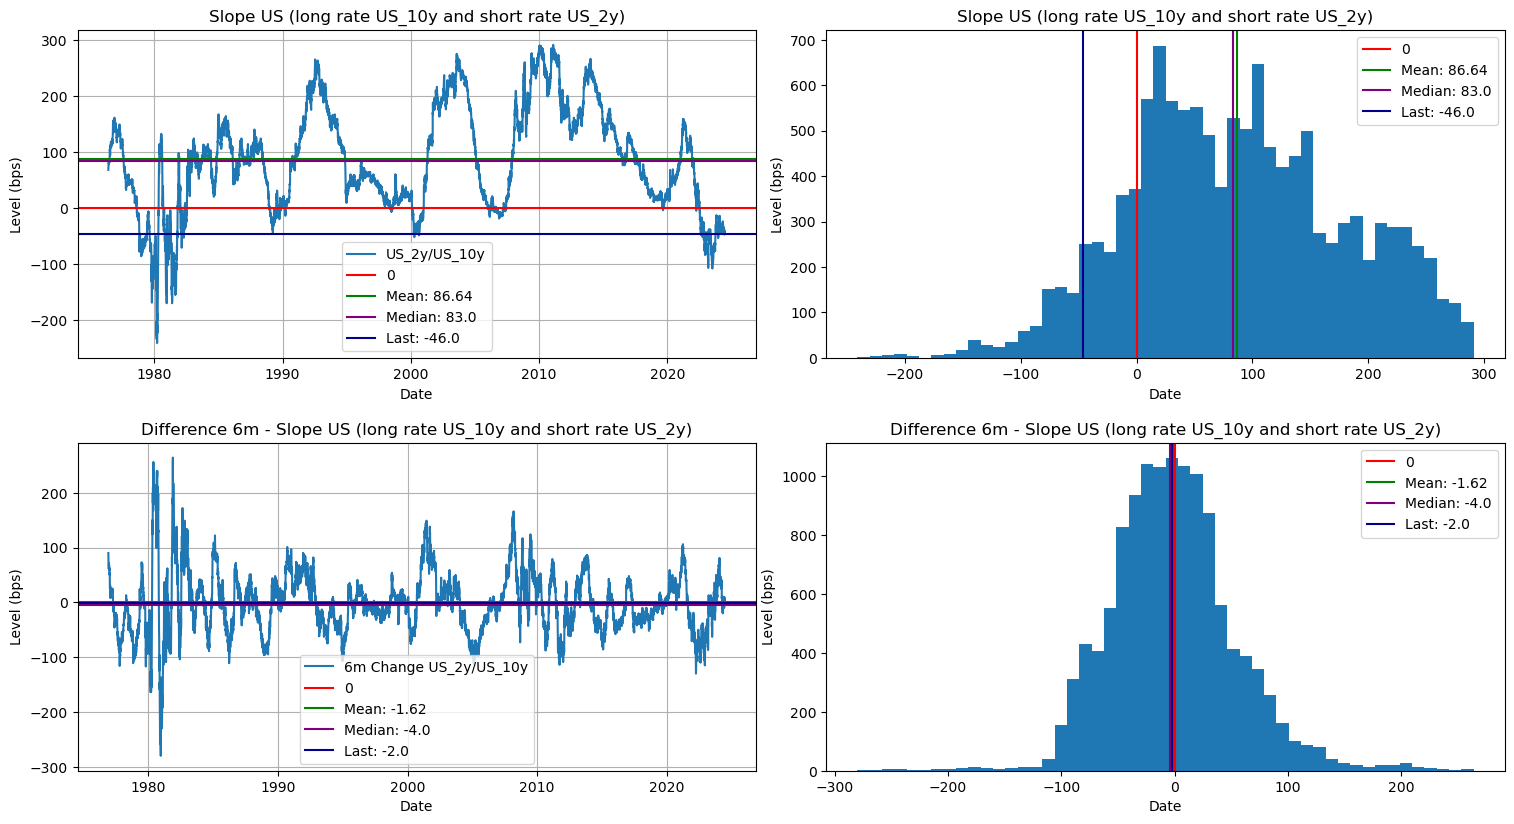

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (15,8))
fig.tight_layout(h_pad = 4, w_pad = 2)

axs[0,0].plot(US2y10y, label = US2y10y.columns[0])
axs[0,0].axhline(0, color = "red", label = "0")
axs[0,0].axhline(US2y10y.mean()[0], color = "green", label = "Mean: " + str(round(US2y10y.mean()[0],2)))
axs[0,0].axhline(US2y10y.median()[0], color = "purple", label = "Median: " + str(round(US2y10y.median()[0],2)))
axs[0,0].axhline(US2y10y.iloc[-1,:][0], color = "darkblue", label = "Last: " + str(round(US2y10y.iloc[-1,:][0],2)))
axs[0,0].set_title("Slope US (long rate US_10y and short rate US_2y)")
axs[0,0].set_xlabel("Date")
axs[0,0].set_ylabel("Level (bps)")
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].hist(US2y10y, bins  = 50)
axs[0,1].axvline(0, color = "red", label = "0")
axs[0,1].axvline(US2y10y.mean()[0], color = "green", label = "Mean: " + str(round(US2y10y.mean()[0],2)))
axs[0,1].axvline(US2y10y.median()[0], color = "purple", label = "Median: " + str(round(US2y10y.median()[0],2)))
axs[0,1].axvline(US2y10y.iloc[-1,:][0], color = "darkblue", label = "Last: " + str(round(US2y10y.iloc[-1,:][0],2)))
axs[0,1].set_title("Slope US (long rate US_10y and short rate US_2y)")
axs[0,1].set_xlabel("Date")
axs[0,1].set_ylabel("Level (bps)")
axs[0,1].legend()

axs[1,0].plot(diff_6m_US2y10y, label = diff_6m_US2y10y.columns[0])
axs[1,0].axhline(0, color = "red", label = "0")
axs[1,0].axhline(diff_6m_US2y10y.mean()[0], color = "green", label = "Mean: " + str(round(diff_6m_US2y10y.mean()[0],2)))
axs[1,0].axhline(diff_6m_US2y10y.median()[0], color = "purple", label = "Median: " + str(round(diff_6m_US2y10y.median()[0],2)))
axs[1,0].axhline(diff_6m_US2y10y.iloc[-1,:][0], color = "darkblue", label = "Last: " + str(round(diff_6m_US2y10y.iloc[-1,:][0],2)))
axs[1,0].set_title("Difference 6m - Slope US (long rate US_10y and short rate US_2y)")
axs[1,0].set_xlabel("Date")
axs[1,0].set_ylabel("Level (bps)")
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].hist(diff_6m_US2y10y, bins  = 50)
axs[1,1].axvline(0, color = "red", label = "0")
axs[1,1].axvline(diff_6m_US2y10y.mean()[0], color = "green", label = "Mean: " + str(round(diff_6m_US2y10y.mean()[0],2)))
axs[1,1].axvline(diff_6m_US2y10y.median()[0], color = "purple", label = "Median: " + str(round(diff_6m_US2y10y.median()[0],2)))
axs[1,1].axvline(diff_6m_US2y10y.iloc[-1,:][0], color = "darkblue", label = "Last: " + str(round(diff_6m_US2y10y.iloc[-1,:][0],2)))
axs[1,1].set_title("Difference 6m - Slope US (long rate US_10y and short rate US_2y)")
axs[1,1].set_xlabel("Date")
axs[1,1].set_ylabel("Level (bps)")
axs[1,1].legend()

#### 2) Sector Indices 

array([[<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>]], dtype=object)

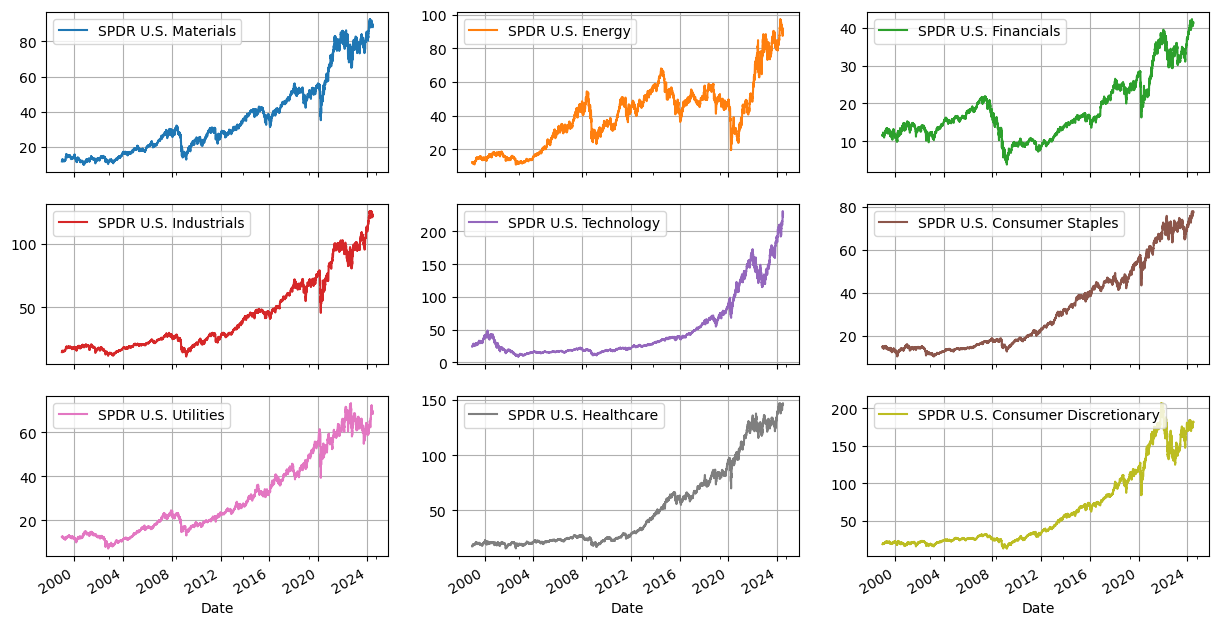

In [9]:
close_price_data.plot(subplots = True, layout = (3,3), grid = True, figsize = (15,8))

array([[<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
        <Axes: xlabel='Date'>]], dtype=object)

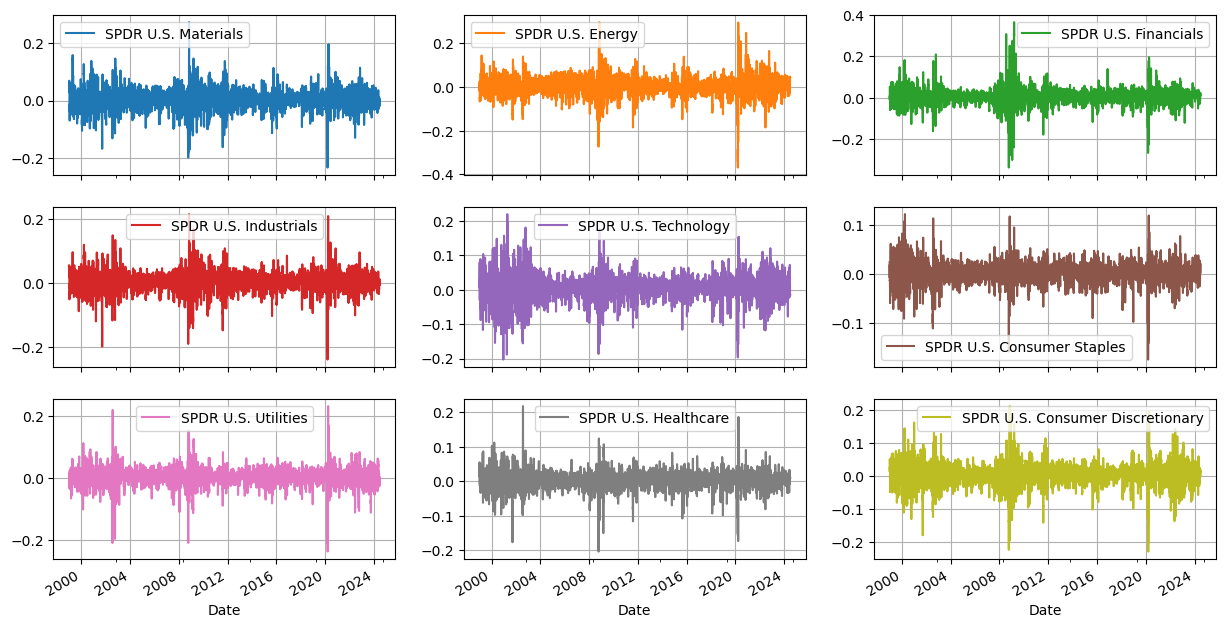

In [10]:
return_close_price = close_price_data.pct_change(periods = 6).dropna()
return_close_price.plot(subplots = True, layout = (3,3), grid = True, figsize = (15,8))

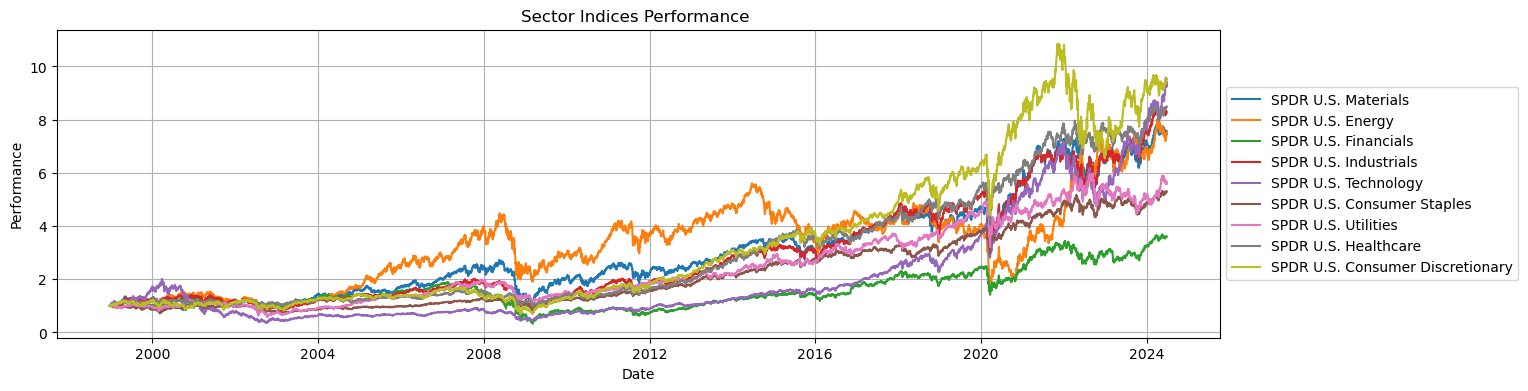

In [11]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(performance_close_price, label = performance_close_price.columns)
ax.set_title("Sector Indices Performance ")
ax.set_xlabel("Date")
ax.set_ylabel("Performance")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

### II. Historical Exposure Steepner US_2y10y in Sector Indices

In [12]:
US2y10y = US2y10y[US2y10y.index.isin(close_price_data.index)]
close_price_data = close_price_data[close_price_data.index.isin(US2y10y.index)]

In [13]:
df_y = US2y10y[US2y10y.index.isin(close_price_data.index)]
df_X = close_price_data[close_price_data.index.isin(US2y10y.index)]

In [14]:
df_ols_coef, y_Matrix, score_metrics = get_ols(df_X, df_y)

Text(0, 0.5, 'Beta')

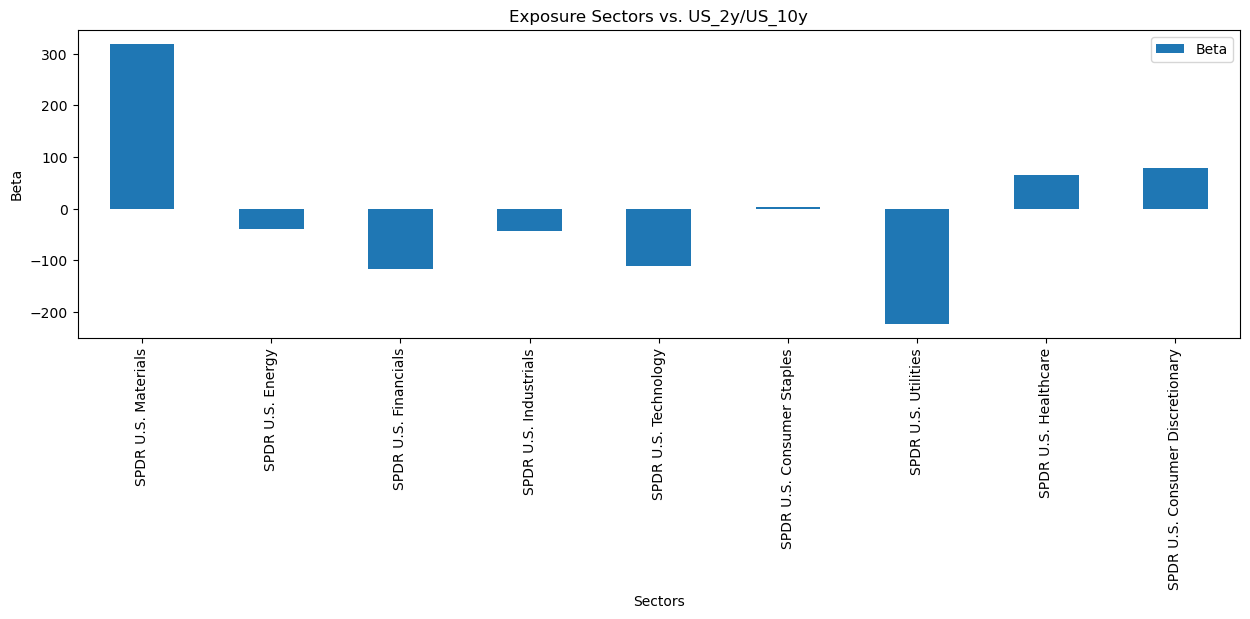

In [15]:
fig, ax = plt.subplots(figsize = (15,4))
df_ols_coef.T.plot(kind = "bar", ax = ax)
ax.set_title("Exposure Sectors vs. US_2y/US_10y")
ax.set_xlabel("Sectors")
ax.set_ylabel("Beta")

In [16]:
score_metrics

,R2 Score,Adj R2 Score
Metrics,0.70962,0.709212


### III. Historical Sector Indices Performance 

In [17]:
risk_metrics = get_risk_metrics(close_price_data)
risk_metrics

,Volatility,Skewness,Excess Kurtosis,Sharpe Ratio,Max Drawdown,Norm. Max Drawdown,VAR 99.0%,ES 99.0%
SPDR U.S. Materials,0.239327,0.938418,-3.146191,0.452480,-0.598248,-2.499705,0.041391,0.000095
SPDR U.S. Energy,0.289990,0.456980,-3.147323,0.419072,-0.712628,-2.457421,0.047038,0.000126
SPDR U.S. Financials,0.289700,1.020156,-2.741195,0.319344,-0.826865,-2.854208,0.050623,0.000589
SPDR U.S. Industrials,0.213083,1.030789,-3.093334,0.497367,-0.622627,-2.921991,0.037323,0.000031
SPDR U.S. Technology,0.259013,1.671340,-1.221784,0.466252,-0.820465,-3.167665,0.045815,0.000175
SPDR U.S. Consumer Staples,0.153607,0.789779,-3.723170,0.504518,-0.358891,-2.336419,0.027122,-0.000016
SPDR U.S. Utilities,0.194892,0.771563,-3.719690,0.447709,-0.522724,-2.682115,0.033409,0.000048
SPDR U.S. Healthcare,0.180025,1.023921,-3.280993,0.557193,-0.391703,-2.175831,0.030408,-0.000026
SPDR U.S. Consumer Discretionary,0.226806,1.091833,-3.103905,0.504255,-0.590475,-2.603436,0.038655,0.000110


### IV. Scenarios Exposure Steepner US_2y10y in Sector Indices

In [18]:
scenario_100_50 = diff_6m_US2y10y[(diff_6m_US2y10y>=-100)&(diff_6m_US2y10y<-50)].dropna()
scenario_50_0 = diff_6m_US2y10y[(diff_6m_US2y10y>=-50)&(diff_6m_US2y10y<0)].dropna()
scenario_0_50 = diff_6m_US2y10y[(diff_6m_US2y10y>=0)&(diff_6m_US2y10y<50)].dropna()
scenario_50_100 = diff_6m_US2y10y[(diff_6m_US2y10y>=50)&(diff_6m_US2y10y<100)].dropna()
scenario_100_150 = diff_6m_US2y10y[(diff_6m_US2y10y>=100)&(diff_6m_US2y10y<150)].dropna()
scenario_150_200 = diff_6m_US2y10y[(diff_6m_US2y10y>=150)&(diff_6m_US2y10y<200)].dropna()

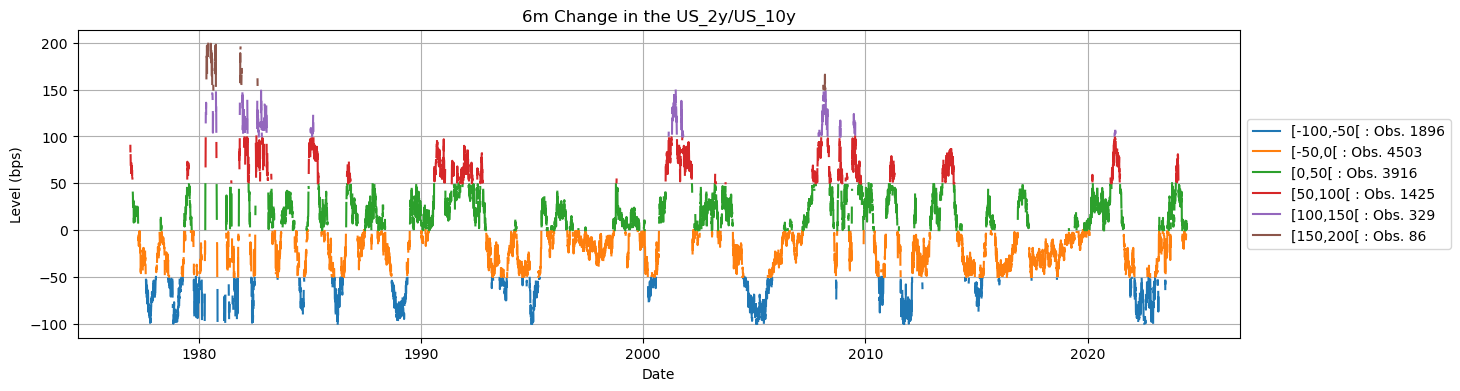

In [19]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(scenario_100_50.resample("D").last(), label = "[-100,-50[ : Obs. "+str(len(scenario_100_50)))
ax.plot(scenario_50_0.resample("D").last(), label = "[-50,0[ : Obs. "+str(len(scenario_50_0)))
ax.plot(scenario_0_50.resample("D").last(), label = "[0,50[ : Obs. "+str(len(scenario_0_50)))
ax.plot(scenario_50_100.resample("D").last(), label = "[50,100[ : Obs. "+str(len(scenario_50_100)))
ax.plot(scenario_100_150.resample("D").last(), label = "[100,150[ : Obs. "+str(len(scenario_100_150)))
ax.plot(scenario_150_200.resample("D").last(), label = "[150,200[ : Obs. "+str(len(scenario_150_200)))
ax.set_title("6m Change in the US_2y/US_10y")
ax.set_xlabel("Date")
ax.set_ylabel("Level (bps)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

In [20]:
dict_ols_coeff = {}
dict_score_metrics = {}
dict_y_matrix = {}
dict_residuals = {}

list_name_scenarios = ["[-100,-50[","[-50,0[","[0,50[", "[50,100[", "[100,150[", "[150,200["]
list_scenarios = [scenario_100_50, scenario_50_0, scenario_0_50, scenario_50_100, scenario_100_150, scenario_150_200]

for name_scenario, scenario in zip(list_name_scenarios, list_scenarios):
    try : 
        df_y = US2y10y[US2y10y.index.isin(scenario.index)]
        df_X = close_price_data[close_price_data.index.isin(scenario.index)]
#         df_y = diff_6m_US2y10y[diff_6m_US2y10y.index.isin(scenario.index)]
#         df_X = return_close_price[return_close_price.index.isin(scenario.index)]
        dict_ols_coeff[name_scenario], dict_y_matrix[name_scenario], dict_score_metrics[name_scenario] = get_ols(df_X, df_y)
        dict_residuals[name_scenario] = dict_y_matrix[name_scenario]["y"] - dict_y_matrix[name_scenario]["y predict"]
        print(name_scenario)
    except ValueError :
        pass

[-100,-50[
[-50,0[
[0,50[
[50,100[
[100,150[
[150,200[


In [21]:
score_metrics_data = pd.concat(dict_score_metrics).swaplevel()
ols_coeff_data = pd.concat(dict_ols_coeff).swaplevel()
residuals_data = pd.concat(dict_residuals, axis = 1)

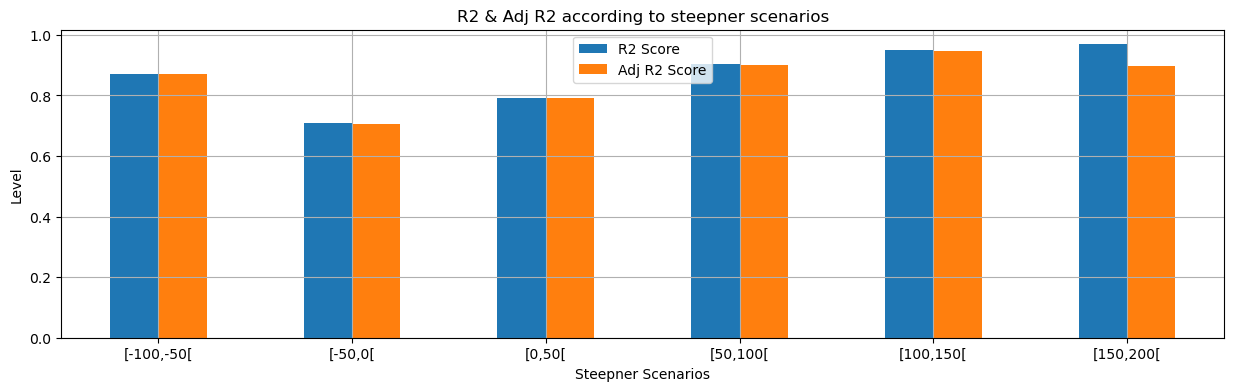

In [22]:
fig, ax = plt.subplots(figsize = (15,4))
score_metrics_data.xs("Metrics", axis = 0).plot(kind="bar", rot = 0, ax = ax)
ax.set_title("R2 & Adj R2 according to steepner scenarios")
ax.set_xlabel("Steepner Scenarios")
ax.set_ylabel("Level")
ax.grid()

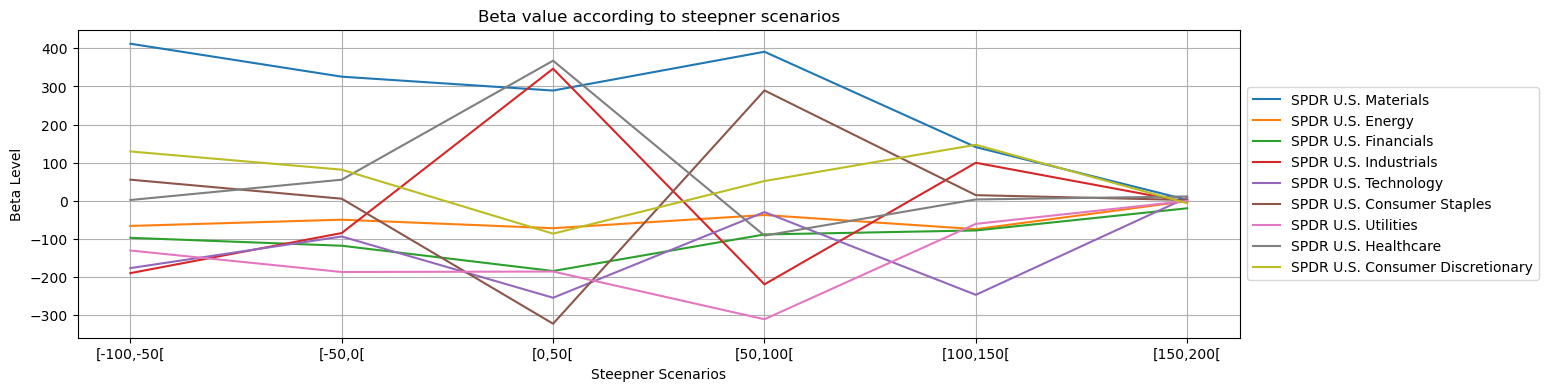

In [23]:
fig, ax = plt.subplots(figsize = (15,4))
ols_coeff_data.xs("Beta", axis = 0).plot(kind="line", rot = 0, ax = ax)
ax.set_title("Beta value according to steepner scenarios")
ax.set_xlabel("Steepner Scenarios")
ax.set_ylabel("Beta Level")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

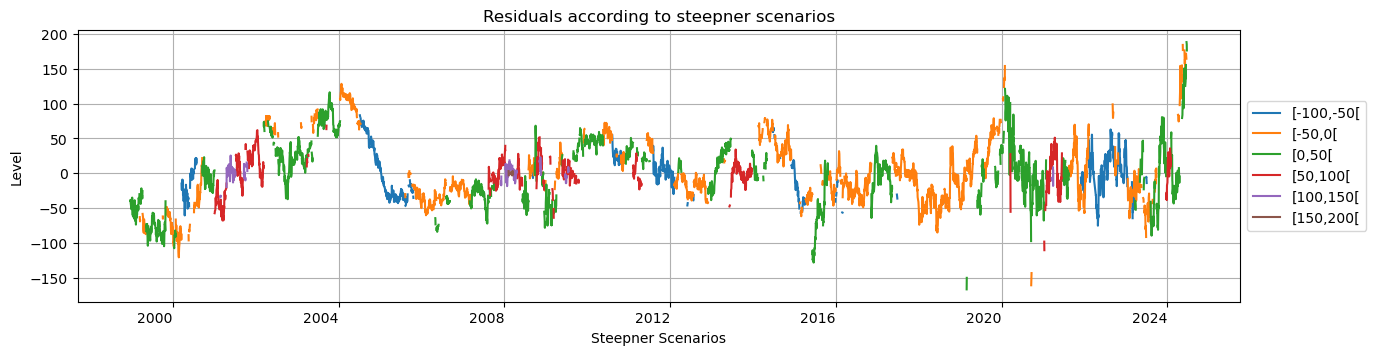

In [24]:
fig, ax = plt.subplots(figsize = (15,4))
residuals_data.plot(kind="line", rot = 0, ax = ax)
ax.set_title("Residuals according to steepner scenarios")
ax.set_xlabel("Steepner Scenarios")
ax.set_ylabel("Level")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

<bound method Axes.legend of <Axes: title={'center': '[150,200['}, xlabel='True', ylabel='Prediction'>>

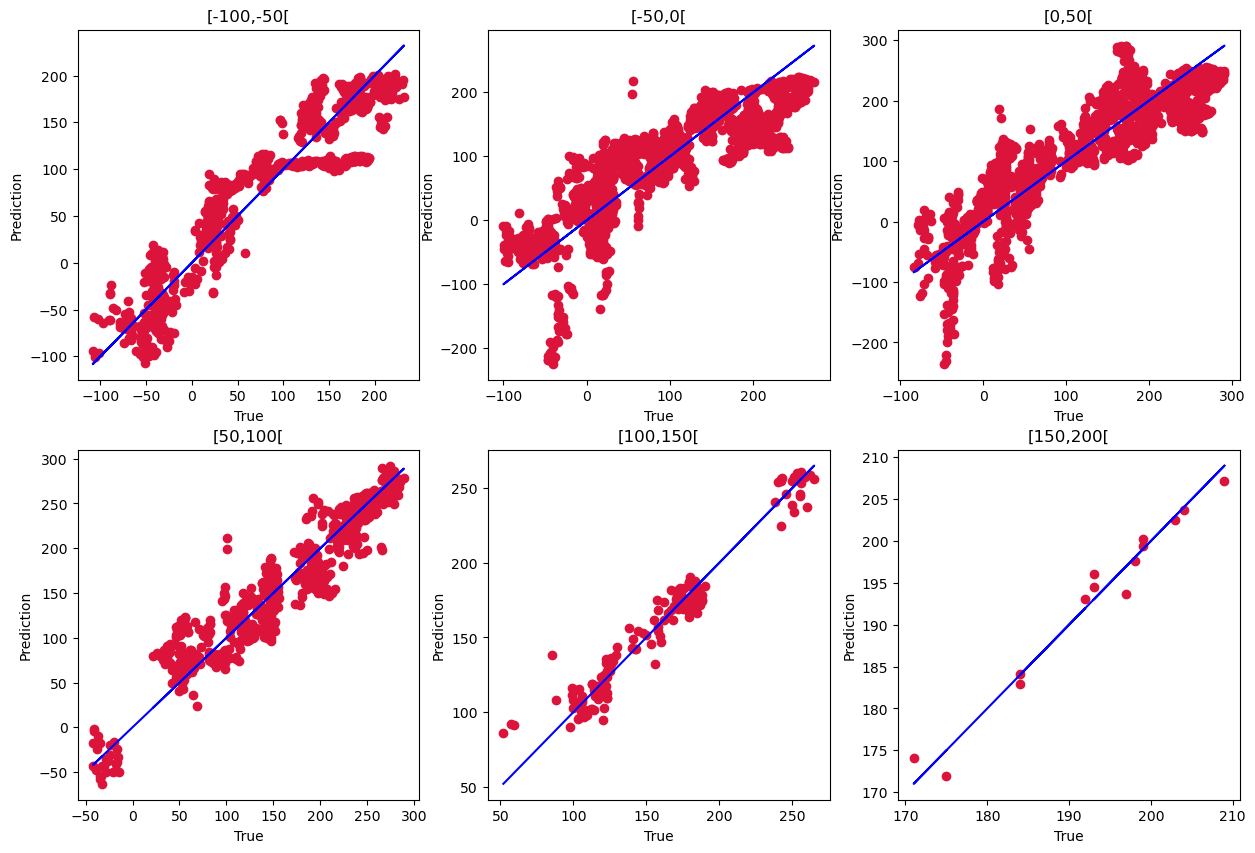

In [25]:
list_name_scenarios = ["[-100,-50[","[-50,0[","[0,50[", "[50,100[", "[100,150[", "[150,200["]


fig, axs = plt.subplots(2,3,figsize = (15,10))
scenarios_y_matrix = dict_y_matrix["[-100,-50["]
true_value = scenarios_y_matrix["y"]
predicted_value = scenarios_y_matrix["y predict"]
axs[0,0].scatter(true_value, predicted_value, c = "crimson")
axs[0,0].plot(true_value, true_value, 'b-')
axs[0,0].set_title("[-100,-50[")
axs[0,0].set_xlabel("True")
axs[0,0].set_ylabel("Prediction")
axs[0,0].legend

scenarios_y_matrix = dict_y_matrix["[-50,0["]
true_value = scenarios_y_matrix["y"]
predicted_value = scenarios_y_matrix["y predict"]
axs[0,1].scatter(true_value, predicted_value, c = "crimson")
axs[0,1].plot(true_value, true_value, 'b-')
axs[0,1].set_title("[-50,0[")
axs[0,1].set_xlabel("True")
axs[0,1].set_ylabel("Prediction")
axs[0,1].legend

scenarios_y_matrix = dict_y_matrix["[0,50["]
true_value = scenarios_y_matrix["y"]
predicted_value = scenarios_y_matrix["y predict"]
axs[0,2].scatter(true_value, predicted_value, c = "crimson")
axs[0,2].plot(true_value, true_value, 'b-')
axs[0,2].set_title("[0,50[")
axs[0,2].set_xlabel("True")
axs[0,2].set_ylabel("Prediction")
axs[0,2].legend

scenarios_y_matrix = dict_y_matrix["[50,100["]
true_value = scenarios_y_matrix["y"]
predicted_value = scenarios_y_matrix["y predict"]
axs[1,0].scatter(true_value, predicted_value, c = "crimson")
axs[1,0].plot(true_value, true_value, 'b-')
axs[1,0].set_title("[50,100[")
axs[1,0].set_xlabel("True")
axs[1,0].set_ylabel("Prediction")
axs[1,0].legend

scenarios_y_matrix = dict_y_matrix["[100,150["]
true_value = scenarios_y_matrix["y"]
predicted_value = scenarios_y_matrix["y predict"]
axs[1,1].scatter(true_value, predicted_value, c = "crimson")
axs[1,1].plot(true_value, true_value, 'b-')
axs[1,1].set_title("[100,150[")
axs[1,1].set_xlabel("True")
axs[1,1].set_ylabel("Prediction")
axs[1,1].legend

scenarios_y_matrix = dict_y_matrix["[150,200["]
true_value = scenarios_y_matrix["y"]
predicted_value = scenarios_y_matrix["y predict"]
axs[1,2].scatter(true_value, predicted_value, c = "crimson")
axs[1,2].plot(true_value, true_value, 'b-')
axs[1,2].set_title("[150,200[")
axs[1,2].set_xlabel("True")
axs[1,2].set_ylabel("Prediction")
axs[1,2].legend

### V. Scenarios Sector Indices Performance

In [26]:
dict_scenarios_risk_metrics = {}

list_name_scenarios = ["[-100,-50[","[-50,0[","[0,50[", "[50,100[", "[100,150[", "[150,200["]
list_scenarios = [scenario_100_50, scenario_50_0, scenario_0_50, scenario_50_100, scenario_100_150, scenario_150_200]

for name_scenario, scenario in zip(list_name_scenarios, list_scenarios) :
    dict_scenarios_risk_metrics[name_scenario] = get_risk_metrics(close_price_data[close_price_data.index.isin(scenario.index)])


In [27]:
scenarios_risk_metrics = pd.concat(dict_scenarios_risk_metrics, axis = 1)
scenarios_risk_metrics

[-100,-50[                            \
                                 Volatility  Skewness Excess Kurtosis   
SPDR U.S. Materials                0.597666  0.934542       -3.794349   
SPDR U.S. Energy                   0.571438  0.551061       -3.973850   
SPDR U.S. Financials               0.549304  0.873018       -3.633390   
SPDR U.S. Industrials              0.482367  0.984068       -3.795187   
SPDR U.S. Technology               0.922552  1.140831       -3.450166   
SPDR U.S. Consumer Staples         0.372933  0.876697       -3.959917   
SPDR U.S. Utilities                0.369066  0.923679       -3.842891   
SPDR U.S. Healthcare               0.485035  0.975439       -3.854293   
SPDR U.S. Consumer Discretionary   0.646605  1.121664       -3.375553   

                                                                               \
                                 Sharpe Ratio Max Drawdown Norm. Max Drawdown   
SPDR U.S. Materials                  1.121692    -0.262436          -0.439101   
SPDR U.S. Energy                     1.080326    -0.462683          -0.809682   
SPDR U.S. Financials                 0.784230    -0.552118          -1.005122   
SPDR U.S. Industrials                1.241753    -0.198206          -0.410902   
SPDR U.S. Technology                 0.763811    -0.718983          -0.779341   
SPDR U.S. Consumer Staples           1.530156    -0.163023          -0.437139   
SPDR U.S. Utilities                  1.481154    -0.203284          -0.550808   
SPDR U.S. Healthcare                 1.267641     -0.14567           -0.30033   
SPDR U.S. Consumer Discretionary     1.150042    -0.384289          -0.594318   

                                                        [-50,0[            \
                                 VAR 99.0%  ES 99.0% Volatility  Skewness   
SPDR U.S. Materials               0.052141  0.000709   0.344224  0.765479   
SPDR U.S. Energy                  0.069120 -0.000004   0.432706  0.211608   
SPDR U.S. Financials              0.050812  0.000926   0.402613  0.860139   
SPDR U.S. Industrials             0.041422  0.000118   0.305710  0.756474   
SPDR U.S. Technology              0.048509  0.001138   0.381664  1.818334   
SPDR U.S. Consumer Staples        0.027202 -0.000249   0.216777  0.457999   
SPDR U.S. Utilities               0.036220 -0.000411   0.254995  0.456413   
SPDR U.S. Healthcare              0.034428  0.000050   0.242212  0.781374   
SPDR U.S. Consumer Discretionary  0.048957  0.000246   0.314168  0.957795   

                                  ... [100,150[            [150,200[  \
                                  ... VAR 99.0%  ES 99.0% Volatility   
SPDR U.S. Materials               ...  0.095690  0.001871   0.544567   
SPDR U.S. Energy                  ...  0.073554  0.002934   0.538168   
SPDR U.S. Financials              ...  0.152692  0.004029   0.498298   
SPDR U.S. Industrials             ...  0.107577  0.002829   0.313903   
SPDR U.S. Technology              ...  0.182269  0.003704   0.233287   
SPDR U.S. Consumer Staples        ...  0.043045  0.001133   0.213825   
SPDR U.S. Utilities               ...  0.049300  0.002251   0.222879   
SPDR U.S. Healthcare              ...  0.078449  0.002052   0.192198   
SPDR U.S. Consumer Discretionary  ...  0.130148  0.002434   0.323210   

                                                                         \
                                  Skewness Excess Kurtosis Sharpe Ratio   
SPDR U.S. Materials              -0.019585       -4.070333     1.103728   
SPDR U.S. Energy                 -0.617033       -3.474667     1.937688   
SPDR U.S. Financials              0.289575       -4.461336    -6.038977   
SPDR U.S. Industrials            -0.179671       -2.939821    -0.778392   
SPDR U.S. Technology              0.631385       -3.674881    -2.214350   
SPDR U.S. Consumer Staples        0.647839       -2.543121    -0.876930   
SPDR U.S. Utilities               0.449550       -3.815781    -3.023594   
SPDR U.S. Healthcare 

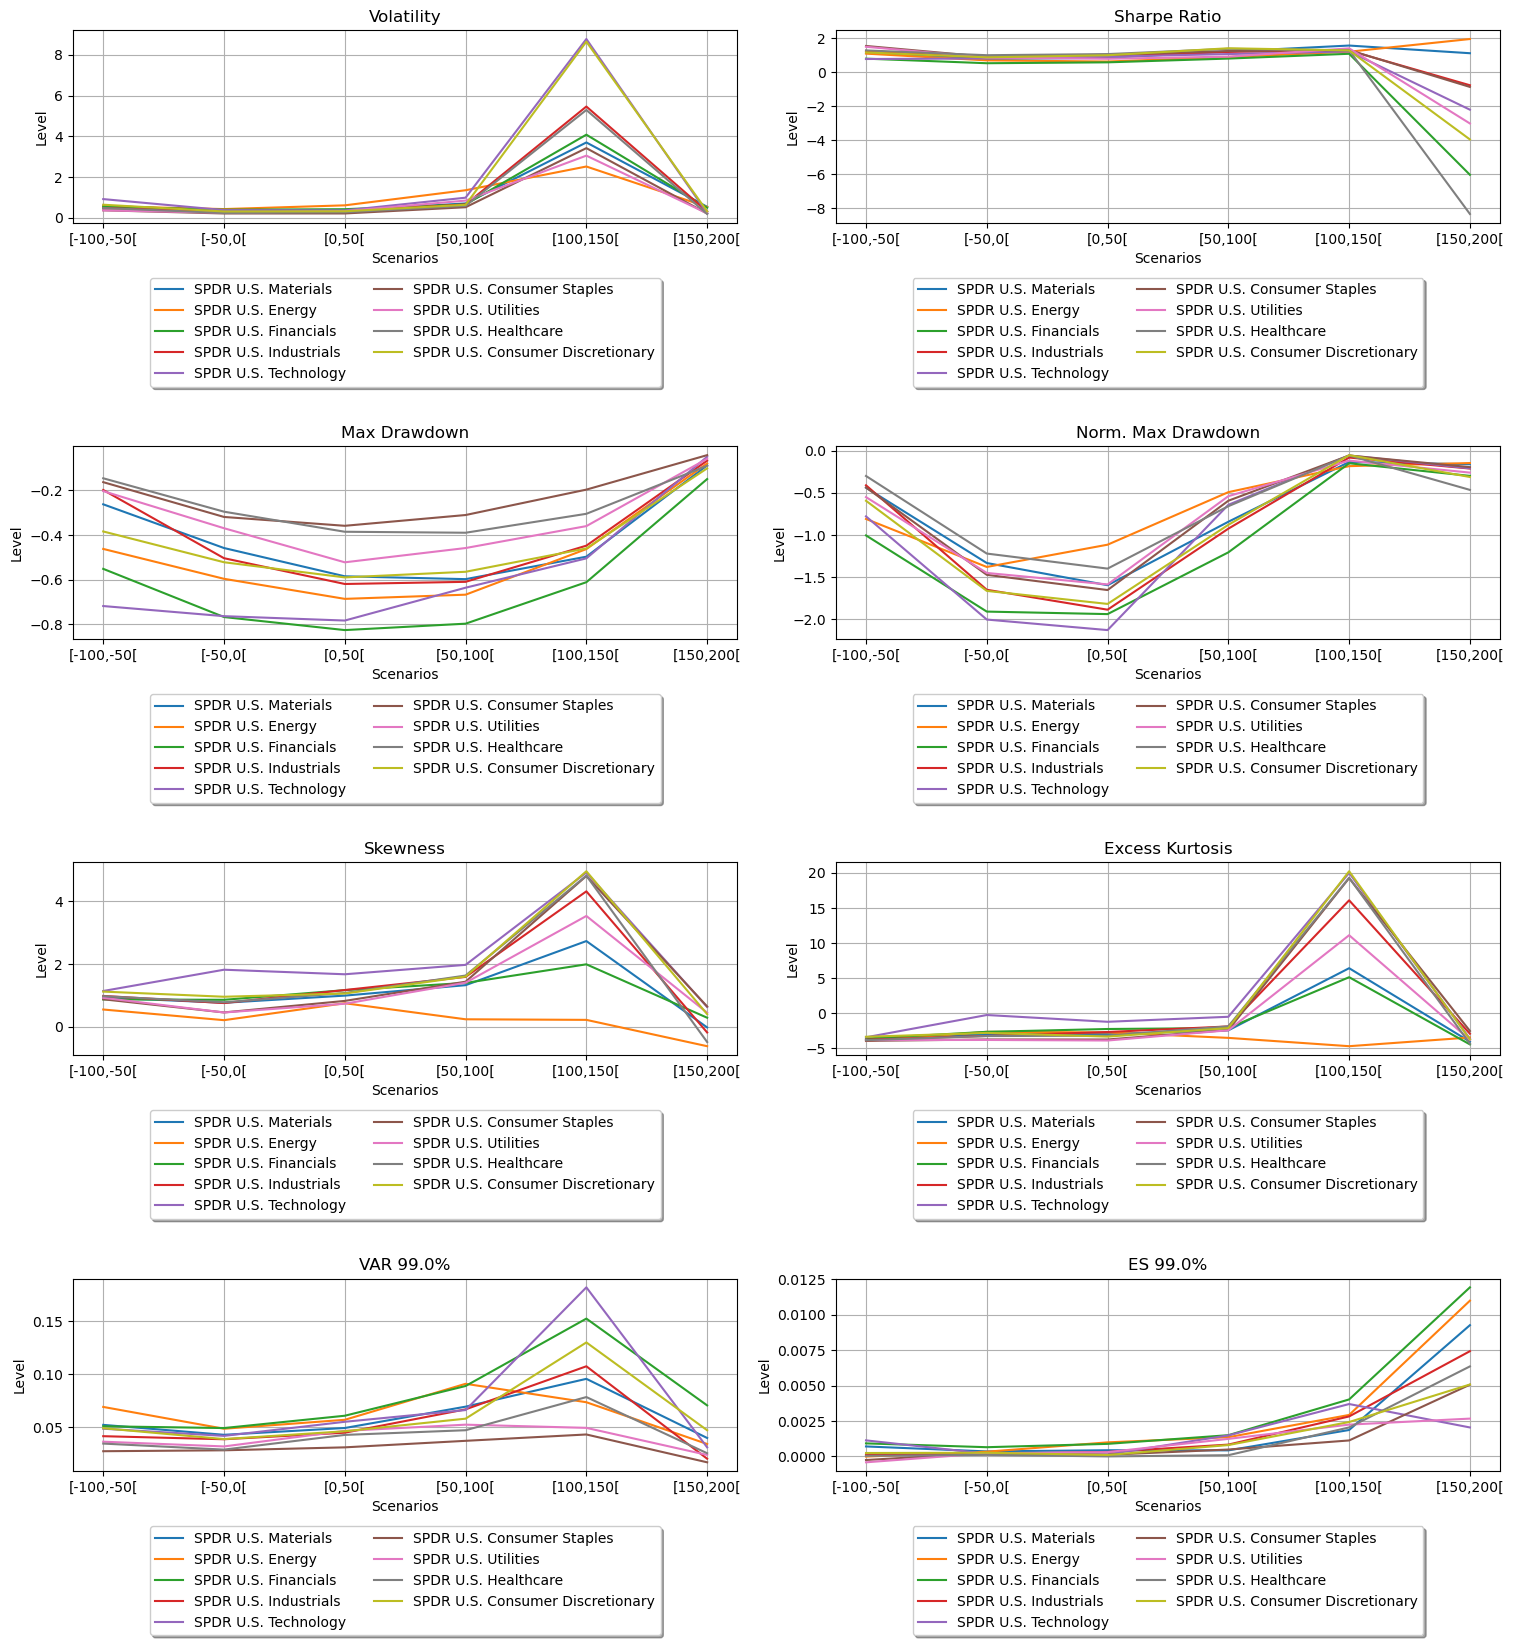

In [28]:
fig, axs = plt.subplots(4, 2, figsize = (15,15))
fig.tight_layout(w_pad = 4, h_pad = 14)
scenarios_risk_metrics.xs("Volatility", level = 1, axis = 1).T.plot(ax = axs[0,0])
axs[0,0].set_title("Volatility")
axs[0,0].set_xlabel("Scenarios")
axs[0,0].set_ylabel("Level")
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[0,0].grid()

scenarios_risk_metrics.xs("Sharpe Ratio", level = 1, axis = 1).T.plot(ax = axs[0,1])
axs[0,1].set_title("Sharpe Ratio")
axs[0,1].set_xlabel("Scenarios")
axs[0,1].set_ylabel("Level")
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[0,1].grid()

scenarios_risk_metrics.xs("Max Drawdown", level = 1, axis = 1).T.plot(ax = axs[1,0])
axs[1,0].set_title("Max Drawdown")
axs[1,0].set_xlabel("Scenarios")
axs[1,0].set_ylabel("Level")
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[1,0].grid()

scenarios_risk_metrics.xs("Norm. Max Drawdown", level = 1, axis = 1).T.plot(ax = axs[1,1])
axs[1,1].set_title("Norm. Max Drawdown")
axs[1,1].set_xlabel("Scenarios")
axs[1,1].set_ylabel("Level")
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[1,1].grid()

scenarios_risk_metrics.xs("Skewness", level = 1, axis = 1).T.plot(ax = axs[2,0])
axs[2,0].set_title("Skewness")
axs[2,0].set_xlabel("Scenarios")
axs[2,0].set_ylabel("Level")
axs[2,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[2,0].grid()

scenarios_risk_metrics.xs("Excess Kurtosis", level = 1, axis = 1).T.plot(ax = axs[2,1])
axs[2,1].set_title("Excess Kurtosis")
axs[2,1].set_xlabel("Scenarios")
axs[2,1].set_ylabel("Level")
axs[2,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[2,1].grid()

scenarios_risk_metrics.xs("VAR 99.0%", level = 1, axis = 1).T.plot(ax = axs[3,0])
axs[3,0].set_title("VAR 99.0%")
axs[3,0].set_xlabel("Scenarios")
axs[3,0].set_ylabel("Level")
axs[3,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[3,0].grid()

scenarios_risk_metrics.xs("ES 99.0%", level = 1, axis = 1).T.plot(ax = axs[3,1])
axs[3,1].set_title("ES 99.0%")
axs[3,1].set_xlabel("Scenarios")
axs[3,1].set_ylabel("Level")
axs[3,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
axs[3,1].grid()